# ¿Cuántos taxis se solicitarán en la próxima hora?

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Para ello probaremos diferentes modelos ajustando sus hipérparámetros y así encontrar el modelo con menor RECM. Nuestreo RECM debe ser menor a 48.

El dataset a usar solo contiene la columna `num_orders`, la cual indica la cantidad de órdenes en el tiempo descrito.

**Tabla de contenido:**

1. Inicialización
2. Cargade datos
3. Análisis de datos
4. Preparación de datos
5. Análisis de serie temporal
6. Formación
7. Prueba
8. Conclusiones

## Inicialización

In [1]:
# Importar librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Carga de datos

In [2]:
# Cargar data
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

## Análisis de datos

In [3]:
# Ver sample de data
data.sample(10)

num_orders
datetime                       
2018-03-18 16:00:00           9
2018-04-28 07:50:00          15
2018-06-12 09:20:00           9
2018-07-25 10:30:00          10
2018-08-22 09:00:00          23
2018-06-30 23:10:00          18
2018-06-27 10:10:00          19
2018-07-12 04:00:00          19
2018-07-23 10:00:00          26
2018-03-07 11:30:00          15

In [4]:
# Ver info de data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Verificar estadísticas descriptivas
data.describe()

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

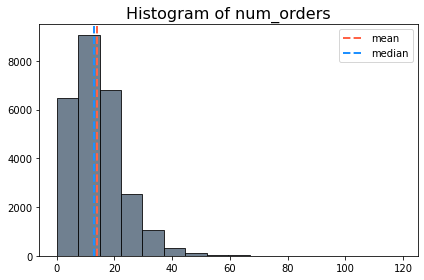

In [6]:
# Graficar Histograma de 'num_orders'
plt.hist(data['num_orders'], bins=16, color='slategray', edgecolor="black", linewidth=0.8)

# Dibujar las líneas verticales para la media y la mediana
mean_val = data['num_orders'].mean()
median_val = data['num_orders'].median()
mean_line = plt.axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
median_line = plt.axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

# Agregar la leyenda
plt.legend([mean_line, median_line], ['mean', 'median'])
plt.title(f'Histogram of num_orders', fontsize=16)

plt.tight_layout()
plt.show()

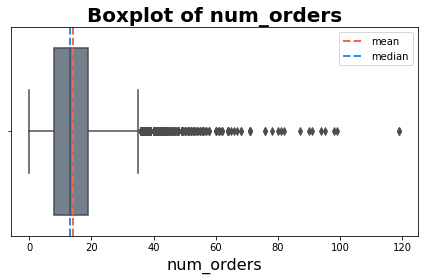

In [7]:
# Graficar Boxplot de 'num_orders'
sns.boxplot(x=data['num_orders'], color='slategray')
plt.title(f'Boxplot of num_orders', fontsize=20, weight='bold')
plt.xlabel('num_orders', fontsize=16)

# Dibujar las líneas verticales para la media y la mediana
mean_val = data['num_orders'].mean()
median_val = data['num_orders'].median()
mean_line = plt.axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
median_line = plt.axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

# Agregar la leyenda
plt.legend([mean_line, median_line], ['mean', 'median'])

plt.tight_layout()
plt.show()

Luego de realizar un análisis de la cantidad de ordenes, podemos ver que la distribución muestra una cola hacia la derecha o sesgo positivo donde la mediana es mayor a la media.

In [8]:
# Verificar fecha máxima y mínima del dataset
print(f'Fecha mínima: {data.index.min()}')
print(f'Fecha máxima: {data.index.max()}')

Fecha mínima: 2018-03-01 00:00:00
Fecha máxima: 2018-08-31 23:50:00


<AxesSubplot:xlabel='datetime'>

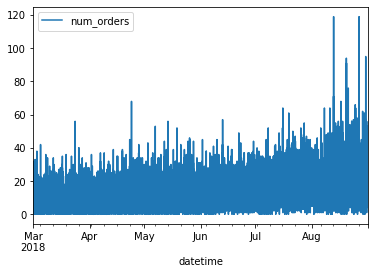

In [9]:
# Graficar número de ordenes
data.plot()

## Preparación

Preparemos los datos para poder realizar los modelos necesarios. Primero veremos si nuestro índice de fecha se encuentra en orden cronológico.

In [10]:
# Verificar que el índice está en orden cronológico
print(data.index.is_monotonic)

True


## Análisis de serie temporal

Luego de preparar nuestro dataset, analizaremos como se comporta la data en la serie temporal. Remuestraremos nuestra data a 1 día para vizualizar el comportamiento. Asimismo, añadiremos la media y desviación estándar móvil con una ventana de 15 días.

In [11]:
# Remuestrear nuestra data a 1 día
data_in_days = data.resample('1D').sum()

# Media movil
rolling_mean = data_in_days.rolling(15).mean()

# Desviación estándar móvil
rolling_std = data_in_days.rolling(15).std()

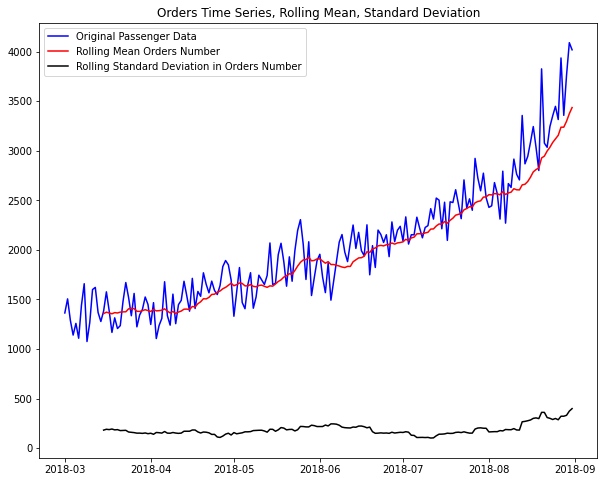

In [12]:
# Graficar medidas
plt.figure(figsize=(10, 8))
plt.plot(data_in_days, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Orders Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Orders Number")
plt.title("Orders Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

Podemos observar una tendencia creciente del número de órdenes de taxi. Asimismo, a incios de julio y pasado de agosto comienza a ver una variación en la desviación estándar de las órdenes, esto quiere decir que durante estos periodos de tiempo la cantidad de órdenes era más variable lo normal.

**Estacionalidad**

Ahora haremos la prueba Dickey-Fuller del paquete de statsmodels para comprobar si nuestra data es o no estacional.

In [13]:
# Aplicar prueba 
adft = adfuller(data_in_days,autolag="AIC")

# Ordenar resultado de prueba
output_data_in_days = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_data_in_days)

       Values                       Metric
0    3.728791              Test Statistics
1    1.000000                      p-value
2   13.000000             No. of lags used
3  170.000000  Number of observations used
4   -3.469413          critical value (1%)
5   -2.878696          critical value (5%)
6   -2.575917         critical value (10%)


El p-value resultante es uno, lo que nos indica de manera significativa que los pedidos de de taxi no sigue un comportamiento estacional.

Lo que también nos servirá, es ver la descomposión de nuestra data en tendencia, estacionalidad y residuos.

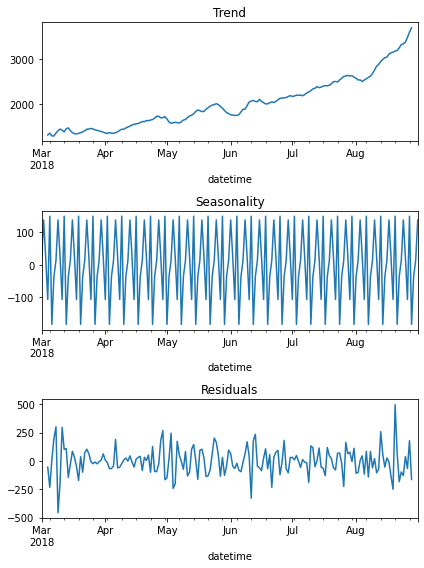

In [14]:
# Descomper data
decomposed = seasonal_decompose(data_in_days)

# Graficar data
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Como mencionamos anteriormente, la tendencia es creciente y no se muestra estacionalidad. Por otro lado, los resudios no muestran ningún tipo de congruencias.

**Autocorrelación**

También es importate mostrar si nuestra serie de tiempo presenta autocorrelación. La autocorrelación en una serie de tiempo muestra que tan está relacionado un punto específico en el timepo con alguno del pasado. Así, por ejemplo, si vemos que existe una gran correlación, podemos inferir que si existe una gran cantiad de órdenes de taxi hoy, también lo habrá en el futuro.

Usaremos el método de autocorrelación de pandas para esto con ventanas de 7, 15, 30 y 60 días.

In [15]:
# Determinar autocorrlaciones
autocorrelation_lag1 = data_in_days['num_orders'].autocorr(lag=7)
print("7 días: ", autocorrelation_lag1)

autocorrelation_lag3 = data_in_days['num_orders'].autocorr(lag=15)
print("15 días: ", autocorrelation_lag3)

autocorrelation_lag6 = data_in_days['num_orders'].autocorr(lag=30)
print("30 días: ", autocorrelation_lag6)

autocorrelation_lag9 = data_in_days['num_orders'].autocorr(lag=60)
print("60 días: ", autocorrelation_lag9)

7 días:  0.9347556137934514
15 días:  0.8656017606960359
30 días:  0.8660362560162489
60 días:  0.7667211096292802


No se muestra ninguna correlación en nuestra data (correlación < 0.8), no podríamos inferir el comportamiento del futuro en función a data del pasado.

## Formación

Previo a comenzar a entrenar y probar modelos, remuestraremos la data a una hora debido a que queremos pronósticar para la siguiente hora y crearemos una función para obtener las características necesarias para nuestro modelo. Adicionalmente, agregaremos las diferencias de en las series temporales los que nos permitirá volver más estacional la data y como consecuencia se hará más factible pronosticar los datos.

In [16]:
# Remuestrar la data a 1 hora
data_in_hours = data.resample('1H').sum()
data_in_hours.sort_index(inplace=True)

In [17]:
# Crear función para añadir características necesarias
def make_features(data, max_lag, rolling_mean_size, rolling_std_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    

In [18]:
# Aplicar función
make_features(data_in_hours, 6, 48, 48)
data_in_hours.head()

num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   

                     lag_3  lag_4  lag_5  lag_6  rolling_mean  
datetime                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN    NaN    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0    NaN    NaN           NaN

## Prueba

Es momento de construir varios modelos de ML para cumplir con el objetivo de la compañía: determinar el valor de merado de un vehículo. Para la construcción de modelos, compararemos modelos de regresión lineal, arból de decisión y bosque aletorio con métodos de potenciación de gradiente: `LightGBM`, `CatBoost` y `XGBoost`.

Adicionalmente, utilizaremos `GridSearchCv` para encontrar los mejores hiperparámetros.

**Prueba de Cordura**

Previo al entrenamiento de diversos modelos, haremos una prueba de cordurar para establecer un medidad base de RECM. Utilizaremos 2 métodos para la prueba de cordura:
1) Todos los valores de la muestra de prueba se pronostican con el mismo número (una constante). Para la métrica RECM, este número es la mediana.

2) El nuevo valor x(t) se predice mediante el valor anterior de la serie, definido como x(t-1). Este método es independiente de la métrica. Considera que el último valor de los datos de entrenamiento se puede utilizar como el primer valor de los datos de prueba.

In [19]:
# Remuestrar la data a 1 hora
data_in_hours_sanity_check = data.resample('1H').sum()

# Determinar conjunto de entrenamiento y de prueba
train, test = train_test_split(data_in_hours_sanity_check, shuffle=False, test_size=0.1)

In [20]:
# Primer método
print('Número de órdenes de taxi medio horaria:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RECM:', mean_squared_error(test, pred_median)**0.5)
difference = (mean_squared_error(test, pred_median)**0.5/test["num_orders"].median())*100
print(f'Diferencia de error: {difference:.3f} %')

Número de órdenes de taxi medio horaria: 135.0
RECM: 87.15277582981295
Diferencia de error: 64.558 %


In [21]:
# Segundo método
print('Número de órdenes de taxi medio horaria:', test['num_orders'].median())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RECM:', mean_squared_error(test, pred_previous)**0.5)
difference = (mean_squared_error(test, pred_previous)**0.5/test["num_orders"].median())*100
print(f'Diferencia de error: {difference:.3f} %')

Número de órdenes de taxi medio horaria: 135.0
RECM: 58.856486242815066
Diferencia de error: 43.597 %


Utilizando el primer método la exactidud de nuestro modelo está lejos de ser exacto. Sin embargo, utilizando el segundo método aumenta la cordura aunque sigo siendo alta. Esto nos sirvirá como punto de referencia para los siguientes modelos.

### Regresión Lineal

Estandarizaremos las características numéricas utilizando **StandarScaler** y usaremos la regresión lineal como nuestra prueba de cordura, buscando que los métodos de potenciación de gradiente presenten una mejor calidad.

In [22]:
# Escalar los datos
scaler = StandardScaler()
data_scaled = data_in_hours
scaler.fit(data_scaled)

# Determinar conjunto de entrenamiento y de prueba
train, test = train_test_split(data_scaled, shuffle=False, test_size=0.1)
train = train.dropna()

# Determinar features y target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento: {features_train.shape}, {target_train.shape}')
print(f'Tamaño del conjunto de prueba: {features_test.shape}, {target_test.shape}')

Tamaño del conjunto de entrenamiento: (3926, 11), (3926,)
Tamaño del conjunto de prueba: (442, 11), (442,)


In [23]:
# Entrenar el modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

# Realizar predicciones
target_pred = lr_model.predict(features_test)

# Establecer las métricas de tiempo y calidad
RECM_lr = mean_squared_error(target_test, target_pred, squared=False)
print(f'RECM de modelo de Regresión Lineal: {RECM_lr:.3f}')

RECM de modelo de Regresión Lineal: 51.681


El modelo de Regresión Lineal obtuvo un RECM de 53.997, este será nuestra prueba de cordura y servirá como valor base para comparar con otro modelos y método de potenciación gradiente.

Si un modelo de potenciación de gradiente obtiene un RECM mayor 53.997 algo habrá salido mal. 

### Árbol de Decisión

Para el caso de modelo de árboloes y regresión logística no es necesario escalar los datos, por lo cual no los estandarizaremos.

In [24]:
# Determinar conjunto de entrenamiento y de prueba
train, test = train_test_split(data_in_hours, shuffle=False, test_size=0.1)
train = train.dropna()

# Determinar features y target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento: {features_train.shape}, {target_train.shape}')
print(f'Tamaño del conjunto de prueba: {features_test.shape}, {target_test.shape}')

Tamaño del conjunto de entrenamiento: (3926, 11), (3926,)
Tamaño del conjunto de prueba: (442, 11), (442,)


**Ajuste de Hiperparámetros**

In [25]:
# Establecer los hiperparámetros de árbol de decisión
params_dt = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8, 9, 10],
    'min_samples_leaf': [2, 4, 6, 8, 9, 10]
}

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=params_dt,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [26]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
gridSearch_dt.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [2, 4, 6, 8, 9, 10],
                         'min_samples_split': [2, 4, 6, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [27]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_dt.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_dt.cv_results_['params'][best_index]
best_score = gridSearch_dt.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

Mejores hiperparámetros: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 2} | Mejor RECM: 29.285


**Entrenamiento de Modelo**

In [28]:
# Entrenar el modelo de árbol de decisión
dt_model = DecisionTreeRegressor(max_depth=7, min_samples_split=8, min_samples_leaf=2, random_state=12345)
dt_model.fit(features_train, target_train)

# Realizar predicciones
target_pred_dt = dt_model.predict(features_test)

# Establecer las metrícas de tiempo y calidad
RECM_dt = mean_squared_error(target_test, target_pred_dt, squared=False)
print(f'RECM de modelo de Árbol de Decisión: {RECM_dt:.3f}')

RECM de modelo de Árbol de Decisión: 49.870


### Bosque Aleatorio

**Ajuste de Hiperparámetros**

In [29]:
# Establecer los hiperparámetros de árbol de decisión
params_rf = {
    'n_estimators': [10, 20, 40, 80, 100],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]
}

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_rf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params_rf,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [30]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
gridSearch_rf.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [10, 20, 40, 80, 100]},
             scoring='neg_root_mean_squared_error')

In [31]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_rf.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_rf.cv_results_['params'][best_index]
best_score = gridSearch_rf.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

Mejores hiperparámetros: {'max_depth': 8, 'n_estimators': 100} | Mejor RECM: 26.908


In [32]:
# Entrenar el modelo de bosque aleatorio
rf_model = RandomForestRegressor(max_depth=8, n_estimators=80, random_state=12345)
rf_model.fit(features_train, target_train)

# Realizar predicciones
target_pred_rf = rf_model.predict(features_test)

# Establecer las metrícas de tiempo y calidad
RECM_rf = mean_squared_error(target_test, target_pred_rf, squared=False)
print(f'RECM de modelo de Bosque Aleatorio: {RECM_rf:.3f}')

RECM de modelo de Bosque Aleatorio: 47.585


### CatBoost

**Ajuste de Hiperparámetros**

In [33]:
# Establecer los hiperparámetros que vamos a ajustar
params_catboost = {
    'depth': [4, 6, 10, 15],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1]
}

# Llamar al estimador que utilizaremos, CatBoostRegressor y lo pasamos a GridSearchCv
catboost_est = CatBoostRegressor(iterations=100, verbose=False, loss_function='RMSE')

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_catboost = GridSearchCV(
    estimator=catboost_est,
    param_grid=params_catboost,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [34]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
gridSearch_catboost.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4d0743eb20>,
             param_grid={'depth': [4, 6, 10, 15],
                         'learning_rate': [0.1, 0.2, 0.5, 0.8, 1]},
             scoring='neg_root_mean_squared_error')

In [35]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_catboost.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_catboost.cv_results_['params'][best_index]
best_score = gridSearch_catboost.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

Mejores hiperparámetros: {'depth': 6, 'learning_rate': 0.1} | Mejor RECM: 25.854


**Entrenamiento de Modelo**

In [36]:
# Entrenar el modelo de catboost
catboost_model = CatBoostRegressor(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    random_state=12345
)

catboost_model.fit(features_train, target_train, verbose=False)

# Realizar predicciones
target_pred_cat = catboost_model.predict(features_test)

# Establecer las metrícas de tiempo y calidad
RECM_cat = mean_squared_error(target_test, target_pred_cat, squared=False)
print(f'RECM de modelo de CatBoost: {RECM_cat:.3f}')

RECM de modelo de CatBoost: 47.674


### LightGBM

**Ajuste de Hiperparámetros**

In [37]:
# Establecer los hiperparámetros que vamos a ajustar
params_lightgbm = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1],
    'num_leaves': [10, 20, 30, 40]
}

# Llamar al estimador que utilizaremos
lightgbm_est = LGBMRegressor()

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_lightgbm = GridSearchCV(
    estimator=lightgbm_est,
    param_grid=params_lightgbm,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [38]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
gridSearch_lightgbm.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2, 0.5, 0.8, 1],
                         'n_estimators': [100, 300, 500, 700],
                         'num_leaves': [10, 20, 30, 40]},
             scoring='neg_root_mean_squared_error')

In [39]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_lightgbm.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_lightgbm.cv_results_['params'][best_index]
best_score = gridSearch_lightgbm.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10} | Mejor RECM: 25.938


**Entrenamiento de Modelo**

In [40]:
# Entrenar el modelo de LightGBM
lightgbm_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=10,
    random_seed=12345
)

lightgbm_model.fit(features_train, target_train)

# Realizar predicciones
target_pred_gbm = lightgbm_model.predict(features_test)

# Establecer las metrícas de tiempo y calidad
RECM_light = mean_squared_error(target_test, target_pred_gbm, squared=False)
print(f'RECM de modelo de LightGBM: {RECM_light:.3f}')

RECM de modelo de LightGBM: 47.619


### XGBoost

**Ajuste de Hiperparámetros**

In [41]:
# Establecer los hiperparámetros que vamos a ajustar
params_xboost = {
    'max_depth': [4, 6, 8, 10, 12],
    'n_estimators': [50, 100, 150, 200]
}

# Llamar al estimador que utilizaremos
xboost_est = XGBRegressor()

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_xboost = GridSearchCV(
    estimator=xboost_est,
    param_grid=params_xboost,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [42]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
gridSearch_xboost.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [43]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_xboost.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_xboost.cv_results_['params'][best_index]
best_score = gridSearch_xboost.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

Mejores hiperparámetros: {'max_depth': 4, 'n_estimators': 50} | Mejor RECM: 26.390


**Entrenamiento de Modelo**

In [44]:
# Entrenar el modelo de XGBoost
xboost_model = XGBRegressor(
    random_estate=12345,
    max_depth=4,
    n_estimators=50
)

xboost_model.fit(features_train, target_train)

# Realizar predicciones
target_pred_xboost = xboost_model.predict(features_test)

# Establecer las metrícas de tiempo y calidad
RECM_xboost = mean_squared_error(target_test, target_pred_xboost, squared=False)
print(f'RECM de modelo de XGBoost: {RECM_xboost:.3f}')

[14:57:37] WARNING: ../src/learner.cc:576: 
Parameters: { "random_estate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RECM de modelo de XGBoost: 46.854


## Conclusiones

Empezamos realizando un análisis a nuestro datos de número de órdenes, donde se tiene un sesgo positivo y lás ódenes se encuentran concentradas en en valores menores. Asimismo, analizamos las series temporales remuestreando a 1 día para hacer más visible la data. Esto nos mostró que hay una tendencia creciente, no hay estacionalidad en los datos y los residuos no muestran alguna congruencia.

Por último se probaron y ajustaron diferentes modelos y se obtuvo que el mejor modelo fue XGBoost con un RECM de 47.85

1. **La solicitud de taxis muestra una tendencia creciente durante el tiempo.**
2. **El mejor modelo para predecir la cantidad de órdenes de taxis en la próxima hora es XGBoost con un RECM de 47.85.**